In [1]:
'''
**********************************************
# TITLE: ASSIGNMENT 2: IMAGE MOSAIC CREATION # 
# #Panorama #Stitching #Blending #Homography #
# COURSE: COL780 - COMPUTER VISION           #
# INSTRUCTOR: PROF. CHETAN ARORA             #
# AUTHOR: AMAN BHARDWAJ                      #
# DATE: 20 NOV 2020                          #
**********************************************
'''
''' IMPORT PACKAGES '''
import os
import cv2 as cv
import json
from glob import glob
import numpy as np
import argparse
import matplotlib.pyplot as plt
from time import time
#%matplotlib inline

In [25]:
a = cv.SIFT_create()
a

<SIFT 0x7f4f02d19510>

Reading Image ---> ./test_set/11/s1.jpg
Reading Image ---> ./test_set/11/s2.jpg


%%%% IMAGE: CLAHE BRIGHTNESS IMPROVED IMAGES, SHAPE: (700, 2631, 3) %%%%


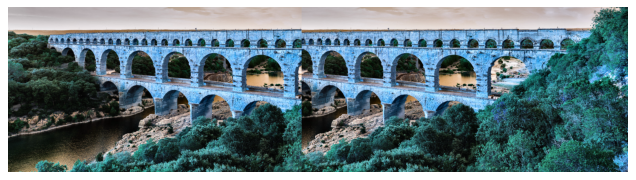



%%%% IMAGE: KNN_MATCHES11, SHAPE: (700, 2631, 3) %%%%


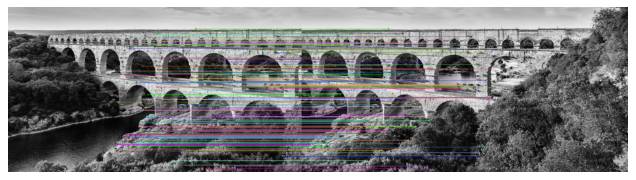

# Good Matches =245, # Minimum Points =40


%%%% IMAGE: MOSAIC11, SHAPE: (1400, 2631, 3) %%%%


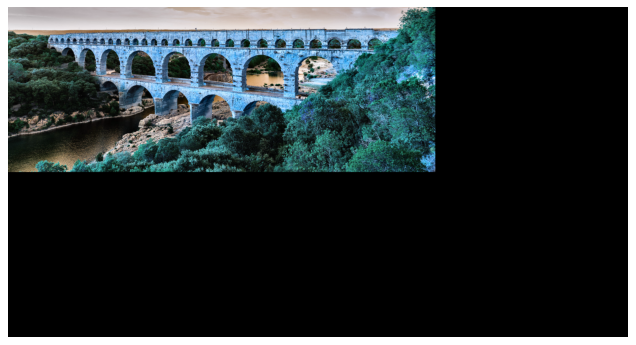

In [41]:
def save_mosaic(fileName, mos):
    '''Save Mosaic in the same folder as createmosaic.py file.'''
    print("Saving --->", fileName)
    cv.imwrite(fileName, mos)
    return

def read_image(fileName):
    '''Read image from the specified path.'''
    print("Reading Image --->", fileName)
    img = cv.imread(fileName)
    return img

def hconcat_images(image_list):
    '''Concat images horizontally'''
    return cv.hconcat(image_list)

def cvt_gray(img):
    '''Convert BRG Image to Grayscale'''
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def brightness_equalize(img):
    img_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)
    return img_output

def apply_clahe(img, limit=1, grid=(8,8)):
    '''
    CLAHE:
    Histogram Equalization and Contrast enhancement
    '''    
    img_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
    
    clahe = cv.createCLAHE(clipLimit=limit, tileGridSize=grid)
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])    
    img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)

    return img_output

def show_image(img, title='Default', save=False):
    '''Display and save image'''
    if img is None:
        print('Could not find image to show.')
    else:        
        print("\n\n%%%% IMAGE: {}, SHAPE: {} %%%%".format(title, img.shape))
        fig = plt.figure(num=0, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
        if save:
            fig.savefig("plots/"+title+".png", dpi=300, format="png")        
    return

def orbs_magic(img, draw=False):
    
    #init ORB
    orb = cv.SIFT_create(nfeatures = 500)
    #detect keypoints
    img = cvt_gray(img)
    keyPoints = orb.detect(img, None)
    #get descriptor
    keyPoints, imgDescriptors = orb.compute(img, keyPoints)
    
    if draw:
        #draw detected keypoints on image and show
        img2 = img
        img2 = cv.drawKeypoints(img,keyPoints,img2,color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        show_image(img2, "ORB_DETECTOR")
        
    return keyPoints, imgDescriptors

def flann_matcher(d1, d2, K=2):
    search_params = {'checks': 50} #default params
    index_params = {'algorithm': 1, 'table_number': 6, 'key_size': 12, 'multi_probe_level': 1, 'trees': 5} #algo = FLANN_INDEX_LSH
    #init flann
    flann = cv.FlannBasedMatcher(index_params, search_params)
    knn_matches = flann.knnMatch(d1, d2, k=K)
    #bf = cv.BFMatcher()
    #bf_matches = bf.knnMatch(d1,d2, k=2)
    return knn_matches
    
def get_good_matches(matches, thresh=0.8):
    good_matches = []
    for m in matches:
        if m[0].distance < thresh * m[1].distance:
            good_matches.append(m[0])
    return good_matches   
    
def draw_matches(img1, img2, k1, k2,  g_matches, draw=False):
    img1 = cvt_gray(img1)
    img2 = cvt_gray(img2)
    match_canvas = cv.drawMatches(img1, k1, img2, k2, g_matches, None, 
                                  flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    if draw:
        show_image(match_canvas, "KNN_MATCHES"+str(i), True)
    return

def est_homography(k1, k2, confident_matches, min_matches=20):
    print("# Good Matches ={}, # Minimum Points ={}".format(len(confident_matches), min_matches))
    if len(confident_matches) >= min_matches:
        points_img1 = [k1[m.queryIdx].pt for m in confident_matches]
        points_img2 = [k2[m.trainIdx].pt for m in confident_matches]
        points_img1 = np.array(points_img1, dtype=np.float32).reshape(-1, 1, 2)
        points_img2 = np.array(points_img2, dtype=np.float32).reshape(-1, 1, 2)
        H, mask = cv.findHomography(points_img2, points_img1, cv.RANSAC, 5.0)
        inliers = list(mask.ravel())
    else:
        print("Number of Good Matches are less than Minimum Points set for Homography estimation.")
        H = inliers = None
    return H, inliers

def stitch_directly(i1, i2, H, show=False):
    h1, w1 = i1.shape[:2]
    h2, w2 = i2.shape[:2]    
    h = h1 + h2
    w = w1 + w2
    tpl = (w,h)
    mosaic = cv.warpPerspective(i2, H, tpl)
    mosaic[0:h1, 0:w1] = i1
    if show:
        show_image(mosaic, "MOSAIC"+str(i))
    return mosaic

def create_mosaic(imgs):
    #read images
    Im1 = imgs[0]
    Img1_ = read_image(Im1)
    Im2 = imgs[1]    
    Img2_ = read_image(Im2)   
    #show_image(hconcat_images([Img1_, Img2_]), "INPUT IMAGES")
    Img1 = apply_clahe(Img1_)
    Img2 = apply_clahe(Img2_)
    show_image(hconcat_images([Img1, Img2]), "CLAHE BRIGHTNESS IMPROVED IMAGES")
    
    #get keypoints and descriptors
    kp1, des1 = orbs_magic(Img1, False)
    kp2, des2 = orbs_magic(Img2, False)
    
    #feature matching by FLANN based Matcher
    knn_matches = flann_matcher(des1, des2)
    confident_matches = get_good_matches(knn_matches, 0.75)
    draw_matches(Img1, Img2, kp1, kp2, confident_matches, True)
    
    #estimate homography using RANSAC
    H, inliers = est_homography(kp1, kp2, confident_matches, 40)
    stitch_directly(Img1, Img2, H, True)
    
    
    return



if __name__ == "__main__":
    
#     input_path = "./val_set/1"
#     print("Input Path =", input_path)
#     images = glob(os.path.join(input_path, "*"))
#     print("Folder Content:",images)
#     if len(images) == 2:
#         print("\nPerfect Input! Let me stitch them for you! ;)")
#         create_mosaic(images)        
#     elif len(images) == 1:
#         print("\nOnly 1 image in folder! Fine. mosaic == input. I can do better! Put 2 images and let me show you what i can do! :P")
#         save_mosaic(images[0].split('/')[-1], cv.imread(images[0]))
#     elif len(images) == 0:
#         print("\nCome on!! You want to create mosaic with no images in folder??? :P")
#     elif len(images) > 2:
#         print("Wooo! Hold on buddy! You are getting too ambitious. Folder contains more than 2 images. :D")
#     else:
#         print("\nSome problem with input folder :( Please check.")
    for i in range(11,12):
        input_path = "./test_set/"+str(i)
        images = glob(os.path.join(input_path, "*"))
        create_mosaic(images)

In [16]:
dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 1)

{'algorithm': 6, 'table_number': 6, 'key_size': 12, 'multi_probe_level': 1}

In [14]:
!jt -t grade3 -f firacode -fs 10 -nfs 11 -T -N

In [22]:
!jt -t grade3 -fs 102 -altp -f firacode -tfs 11 -nfs 110 -cellw 88% -T -N

In [6]:
i1 = cv.imread("./val_set/4/4a.png")
h1, w1 = i1.shape[:2]
h1, w1

(2160, 3840)

In [5]:
i1.shape[:2]

(2160, 3840)

In [7]:
h1

2160